In [9]:
# I.
# -*- coding: utf-8 -*-

import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import seaborn as sns

# II
# Download reference table
w_land = pd.read_csv('/home/hmdg/Documents/Data_Science/Repos/Lands/data/w_land.csv')

#  wlands Backup
w_land = w_land.copy()
#  wlands Backup
w_land = w_land.sort_values(by=['regionw', 'ref'])


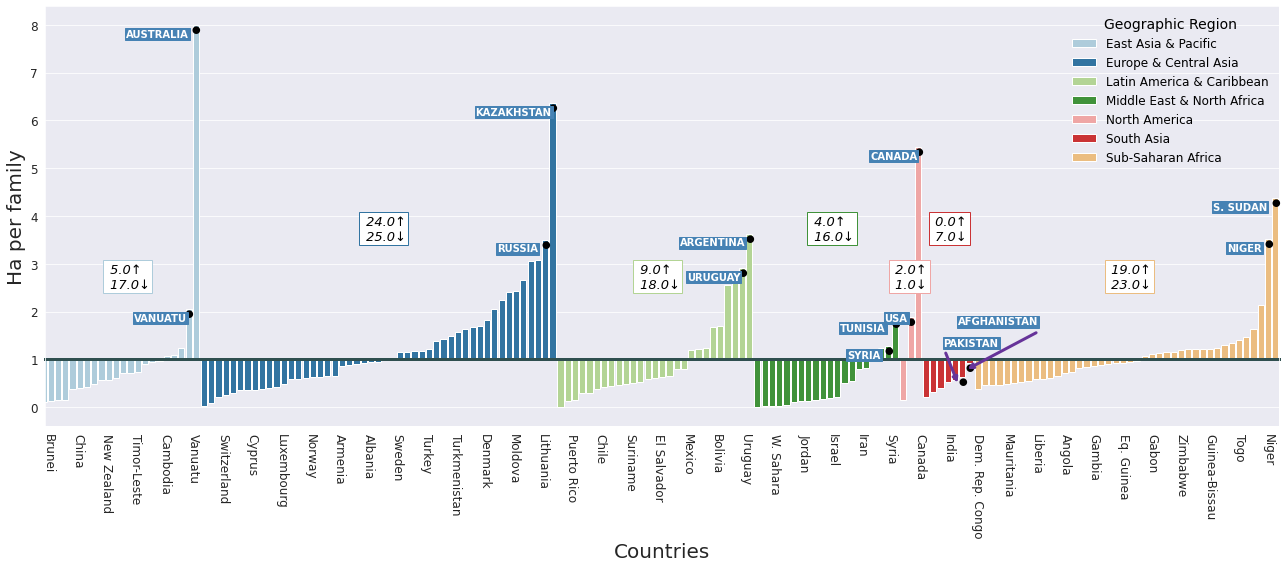

In [10]:
# III Making the ha_ref plot
%matplotlib inline

plt.rcParams.update({'xtick.labelbottom':'on',
                    'ytick.labelleft':'on',
                    'xtick.labelsize':15, 
                    'ytick.labelsize':15,
                    'axes.labelsize':20
                   })

fig= plt.figure(figsize=(18,8))

with sns.axes_style("darkgrid"):
    bx = sns.barplot(x='name_w', y="ref", data=w_land, 
                     #hue='continent', bottom = w_land.ref_val.unique().item(),
                     hue='regionw', bottom = w_land.ref_val.unique().item(),
                     palette="Paired", edgecolor=None)

# Create the list of patches not nulls, for the x axis values.
def patches(bxs):
    patches_heights = []
    for n in range(len(bxs.patches)):
        if (bxs.patches[n].get_height() <0 or bxs.patches[n].get_height() >0):
            s = bxs.patches[n].get_x()
            patches_heights.append(s)
    patches_heights = pd.DataFrame(patches_heights, columns=['xaxis'])
    return(patches_heights)

# Dataframe with the patches of the plot
pop_axis = pd.concat([w_land.reset_index(drop=True), patches(bx).reset_index(drop=True)], axis=1)

pop_axis['name_w'] = pop_axis['name_w'].replace('United States of America','USA')

# Selection of the two first countries for every geo. region named in the plot
popg = pop_axis.groupby(['regionw','name_w']).max()


popg = popg[['HpF', 'xaxis']].sort_values(by=['regionw','HpF'], ascending=False)

l_pays = []

[l_pays.append(popg.loc[p][:2].index[s]) for s in range(2) for p in pop_axis['regionw'].unique()]

# Function to chanche the with of the bars. Its necessary iterate over the patches values.
def change_width(bxs, new_value) : 
    for patch in bxs.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff)

width = 0.85
change_width(bx, width)

# Putting the names of the selected countrys in the plot
def text_names(df,bxs,t):
    ls = []
    if t=='mark':
        for n in l_pays:
            o = bxs.text(float(df['xaxis'][df['name_w']==n])-width, 
                         float(df['HpF'][df['name_w']==n]-0.15),
                         '\u25CF', fontweight='extra bold', rotation=0)
            ls.append(o) 

    else:
        for n in l_pays:
            gap=0.25
            ex = float(df['xaxis'][df['name_w']==n])-len(n)-0.9 #X
            if n == 'USA':
                gap = 0.1
            if n == 'Afghanistan':
                gap = -0.8
                ex = ex + 10
                x = float(df['xaxis'][df['name_w']==n])-width
                y = float(df['HpF'][df['name_w']==n]-0.15)
                plt.annotate("", xy=(ex+len(n), y+0.8), 
                             xytext=(x,y),  
                             arrowprops=dict(arrowstyle="<-", 
                                             lw= 3, linestyle='-', color='rebeccapurple'))
                          
            if n == 'Pakistan':
                gap = -0.65
                ex = ex + 6
                x = float(df['xaxis'][df['name_w']==n])-width
                y = float(df['HpF'][df['name_w']==n]-0.15)
                plt.annotate("", xy=(ex+0.2, y+0.7), 
                             xytext=(x,y),  
                             arrowprops=dict(arrowstyle="<-", 
                                             lw= 3, linestyle='-', color='rebeccapurple'))
                        
            ey =float(df['HpF'][df['name_w']==n]-gap) # Y    
            o = bxs.text(ex, ey,
                         n.upper(), rotation=0, color='white', weight='bold',
                         bbox=dict(boxstyle='square, pad=0.1',
                         fc='steelblue', ec='steelblue'))
            ls.append(o)        
    return ls

text_names(pop_axis,bx,'mark')
text_names(pop_axis,bx,'name')


# Setting the figure 
bx.axhline(w_land.ref_val.unique().item(), color="darkslategray", lw=3, clip_on=False)

bx.tick_params(labelsize=12)
bx.set_xlabel("Countries", fontsize=20)
bx.set_ylabel("Ha per family", fontsize=20)

def colors(bxs):
    patches_colors = []
    for n in range(len(bxs.patches)):
        if (bxs.patches[n].get_height() <0 or bxs.patches[n].get_height() >0):
            s = bxs.patches[n].get_facecolor()
            patches_colors.append([s])
    patches_colors = pd.DataFrame(patches_colors, columns=['color'])
    return(patches_colors)

c_list = colors(bx)['color'].unique()
          
blen = len(bx.get_xticklabels())
bx.set_xticklabels([bx.get_xticklabels()[n] for n in range(0,blen)], rotation=-90)
bx.set_xticks([bx.get_xticks()[n] for n in range(0, blen, 4)])

bx.legend(title='Geographic Region', 
          title_fontsize=14, 
          frameon=False,
          fontsize=12,
         )

# In order to get the values every continent
pp = pop_axis.groupby(['regionw', 'ind']).count()
pp = pp.reset_index(level=['ind']).pivot(columns='ind', values='HpF')
pp['total'] = pp['over']+pp['under']

def noNaN(df,values):
    for v in values:
        df[values] = df[values].replace(np.nan, 0)
        return df[values]

noNaN(pp,['over','total'])

lc = [(pp.loc[n][0], pp.loc[n][1]) for n in pop_axis.regionw.unique()]


# Putting the white squares with ind values for each continent
def text_sq(t1, t2, x, y, color):
    plt.text(x, y, ' '+t1+'\u2191\n '+t2 +'\u2193',
    fontsize=13, fontstyle='oblique',
    bbox=dict(boxstyle='square, pad=0.2', fc='white', ec=color))

def pos_sq():
    l_paysn = []
    [l_paysn.append(popg.loc[p][:2].index[s]) for s in range(1) for p in pop_axis['regionw'].unique()]
    square = pop_axis[['name_w', 'xaxis']][pop_axis.name_w.isin(l_paysn)].reset_index(drop=True)
    sq = []
    for s in range(square.shape[0]):
        if s==0:
            sq.append(square.loc[s,'xaxis']/2)
        else:
            sq.append(square.loc[s-1, 'xaxis']+[(square.loc[s, 'xaxis']-square.loc[s-1, 'xaxis'])/2])
    return(sq)

for num in range(7):
    if (num%2) == 0:
        text_sq(str(lc[num][0]), str(lc[num][1]), pos_sq()[num]-2.4, 2.5, c_list[num])
    else:
        text_sq(str(lc[num][0]), str(lc[num][1]), pos_sq()[num]-2, 3.5, c_list[num])

plt.tight_layout()

plt.savefig('/home/hmdg/Documents/Data_Science/Repos/Lands/images/ha_ref_w.png', bbox_inches='tight')

